In [1]:
import os
import torch    
import h5py
from tqdm import tqdm
#from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import umap
import umap.plot
from autoencoder import SparseAutoencoder
import torch.nn.functional as F
from models.networks import get_model
from data_utils.dataloader import get_loader
from PyTorch_CIFAR10.cifar10_models.vgg import vgg13_bn
from data_utils.data_stats import *
from utils.metrics import topk_acc, real_acc, AverageMeter
from matplotlib import pyplot as plt
%matplotlib inline


Load harvested activations

In [2]:
f = h5py.File("/home/fmassari/scaling_mlps/acts_VGG13_bn_cifar10_test.h5", "r")

for key in f.keys():
    print(key) 
    print(type(f[key])) # get the object type   

group = f[key]
activations = torch.tensor(group[:])
print("Activations Tensor Shape:", activations.shape)

activations
<class 'h5py._hl.dataset.Dataset'>


Activations Tensor Shape: torch.Size([10000, 4096])


Load trained autoencoder

In [3]:
cfg = {
    "seed": 49,
    "buffer_mult": 384,
    "l1_coeff": 3e-4,
    "dict_mult": 3, #expansion factor of the latent representation
    "d_activation": 4096,
    "enc_dtype":"fp32",
}

In [4]:
sparse_autoencoder = SparseAutoencoder(cfg)
print(sparse_autoencoder.W_dec[:, 1].norm())
sparse_autoencoder.load_state_dict(torch.load('SAE_100_epochs_CIFAR10_test_vgg_bn13.pt'))
print(sparse_autoencoder.W_dec[:, 1].norm())
with torch.no_grad():
        loss, decoded, encoded, _, _ = sparse_autoencoder(activations)
        mse = F.mse_loss(activations, decoded, reduction='mean')
        print(f'Mean Squared Error: {mse.item()}')

del sparse_autoencoder
decoded, encoded = decoded.detach().clone(), encoded.detach().clone()

tensor(1.7314, grad_fn=<CopyBackwards>)
tensor(1.8822, grad_fn=<CopyBackwards>)
Mean Squared Error: 1.757688664838497e-06


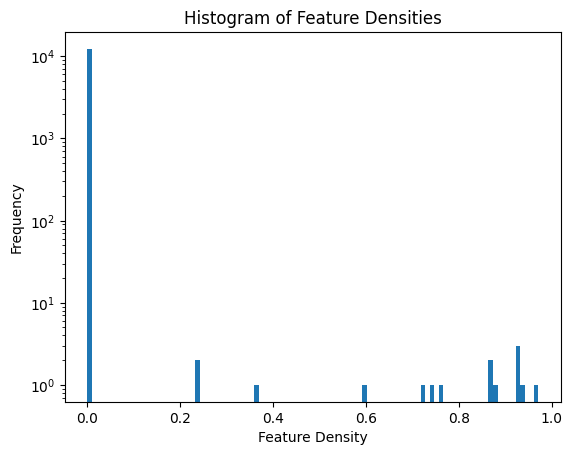

In [5]:
# trying to do some feature interpretation, no idea if that in the right direction    
feature_densities = (encoded != 0).float().mean(dim=0)
plt.hist(feature_densities.numpy(), bins=100, log=True)
plt.xlabel('Feature Density')
plt.ylabel('Frequency')
plt.title('Histogram of Feature Densities')
plt.show()

Load VGG

In [6]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
cifar10_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
data_path = './beton/'
eval_batch_size = 100

torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#model.cuda()
vgg = vgg13_bn(pretrained=True)
state_dict = os.path.join(
                "PyTorch_CIFAR10", "cifar10_models", "state_dicts", "vgg13_bn" + ".pt"
            )
vgg.load_state_dict(torch.load(state_dict))

<All keys matched successfully>

Load dataset and targets

In [7]:
f = h5py.File("/home/fmassari/scaling_mlps/ims_cifar10_test.h5", "r")

for key in f.keys():
    print(key) 
    print(type(f[key])) # get the object type   

group = f[key]
images = torch.tensor(group[:])
print("Images Shape:", images.shape)

f = h5py.File("/home/fmassari/scaling_mlps/targs_cifar10_test.h5", "r")

for key in f.keys():
    print(key) 
    print(type(f[key])) # get the object type   

group = f[key]
targets = torch.tensor(group[:])
print("Targets Shape:", targets.shape)

images
<class 'h5py._hl.dataset.Dataset'>
Images Shape: torch.Size([10000, 3, 32, 32])
targets
<class 'h5py._hl.dataset.Dataset'>
Targets Shape: torch.Size([10000])


In [8]:
#just inspecting some values to make sure the datasets are uncorrupted
#values should be:
print(activations[0, 1]) # 0.039
print(targets[0]) #3
print(images[0, 0, 0, 0]) #0.519

tensor(0.0399)
tensor(3)
tensor(0.5190)


Sanity check #1: make sure that VGG still achieves a test accuracy of 94.209%

In [9]:
with torch.no_grad():
    nsamples = targets.shape[0]
    total_acc, total_top5 = AverageMeter(), AverageMeter()
    batchsize = 100
    vgg.eval()
    
    for r_edge in tqdm(range(batchsize, nsamples+batchsize, batchsize), desc="Evaluation"):
        preds = vgg(images[r_edge-batchsize:r_edge, :, :, :])
        acc, _ = topk_acc(preds, targets[r_edge-batchsize:r_edge], k=5, avg=True)
        total_acc.update(acc, batchsize)

    print(f'Accuracy: {total_acc.get_avg(percentage=True)}')

Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation: 100%|██████████| 100/100 [02:06<00:00,  1.26s/it]

Accuracy: 94.2099980711937


Sanity check #2: make sure that the same test accuracy is achieved when the activations of the VGG are are replaced with the harvested activations (which should be the same).

In [10]:
acts = []
def replace_hook(module, input, output):
    return acts

hook_vgg = vgg._modules['classifier'][4].register_forward_hook(replace_hook)

with torch.no_grad():
    nsamples = targets.shape[0]
    total_acc, total_top5 = AverageMeter(), AverageMeter()
    batchsize = 100
    vgg.eval()
    
    for r_edge in tqdm(range(batchsize, nsamples+batchsize, batchsize), desc="Evaluation"):
        acts = activations[r_edge-batchsize:r_edge, :] #replacing with harvested activations
        preds = vgg(images[r_edge-batchsize:r_edge, :, :, :])
        acc, _ = topk_acc(preds, targets[r_edge-batchsize:r_edge], k=5, avg=True)
        total_acc.update(acc, batchsize)

    print(f'Accuracy: {total_acc.get_avg(percentage=True)}')

hook_vgg.remove()

Evaluation: 100%|██████████| 100/100 [02:11<00:00,  1.31s/it]

Accuracy: 94.2099980711937


## Experiments

replace VGG activations with AE reconstructions to see how much of the accuracy is "explained" by the AE features (i.e., hidden activations)

In [11]:
acts = []
def replace_hook(module, input, output):
    return acts

hook_vgg = vgg._modules['classifier'][4].register_forward_hook(replace_hook)

with torch.no_grad():
    nsamples = targets.shape[0]
    total_acc, total_top5 = AverageMeter(), AverageMeter()
    batchsize = 100
    vgg.eval()
    
    for r_edge in tqdm(range(batchsize, nsamples+batchsize, batchsize), desc="Evaluation"):
        acts = decoded[r_edge-batchsize:r_edge, :] #replacing with activations reconstructed by the AE
        preds = vgg(images[r_edge-batchsize:r_edge, :, :, :])
        acc, _ = topk_acc(preds, targets[r_edge-batchsize:r_edge], k=5, avg=True)
        total_acc.update(acc, batchsize)

    print(f'Accuracy: {total_acc.get_avg(percentage=True)}')

hook_vgg.remove()

Evaluation: 100%|██████████| 100/100 [02:06<00:00,  1.27s/it]

Accuracy: 94.2099980711937


Feature densities

In [12]:
active_units = feature_densities != 0
print("Number of active units in hidden AE-layer: ", (active_units).float().sum())
print("Feature densities of active units: ", feature_densities[active_units])


Number of active units in hidden AE-layer:  tensor(17.)
Feature densities of active units:  tensor([2.4030e-01, 2.4040e-01, 9.2910e-01, 9.7100e-01, 1.0000e-04, 5.9460e-01,
        8.8220e-01, 9.2740e-01, 3.6650e-01, 8.7000e-01, 9.3170e-01, 8.7060e-01,
        7.4560e-01, 7.1970e-01, 7.6110e-01, 1.0000e-04, 9.3480e-01])


## Interpreting non-silent features

Display top 10 activating inputs with corresponding labels for a given non-silent feature

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Showing top activating inputs for feature 1491:


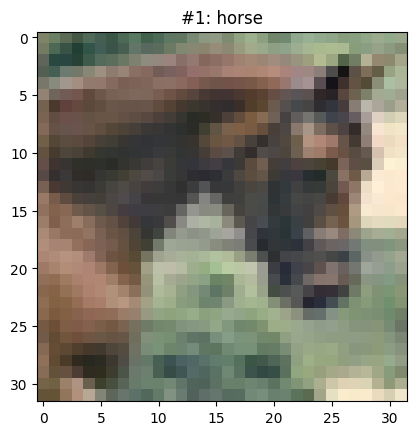

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


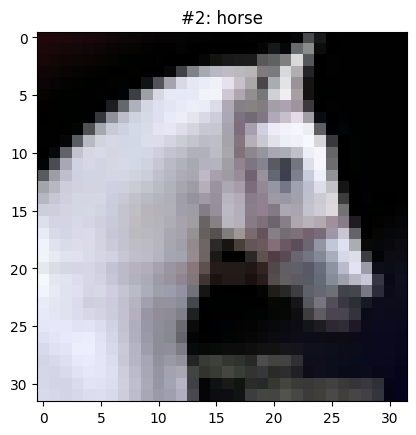

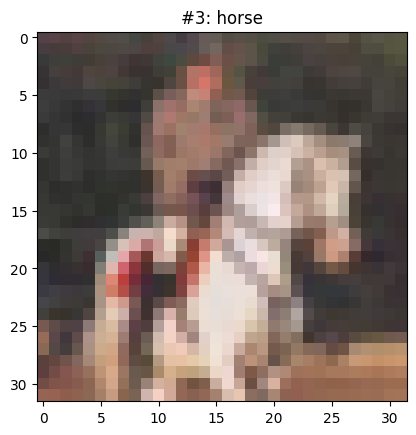

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


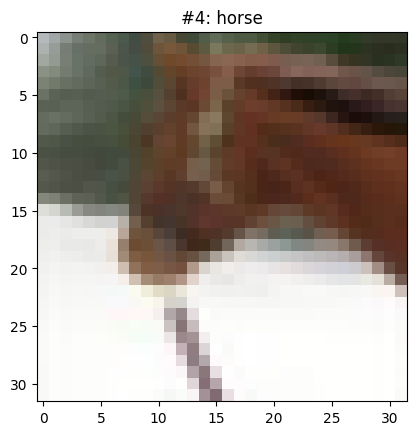

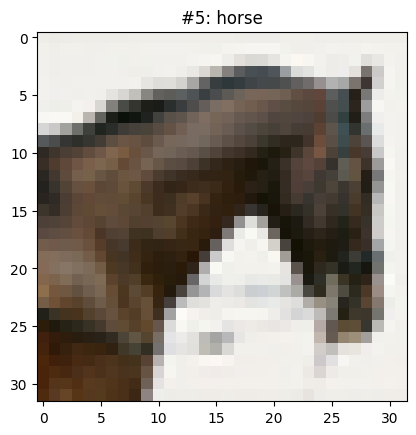

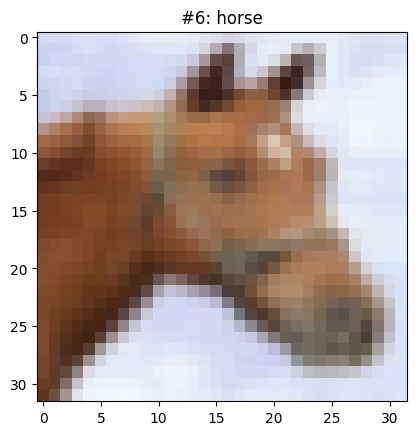

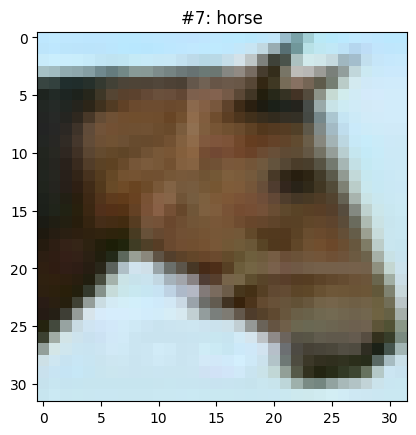

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


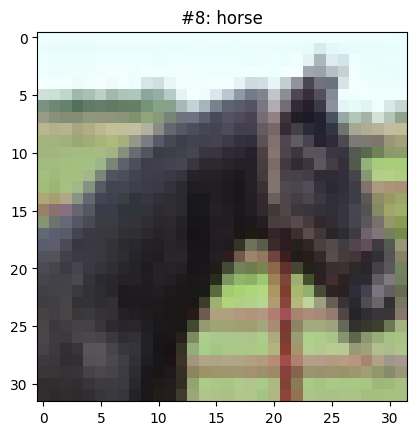

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


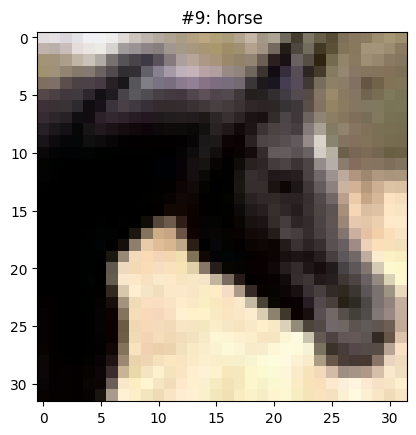

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


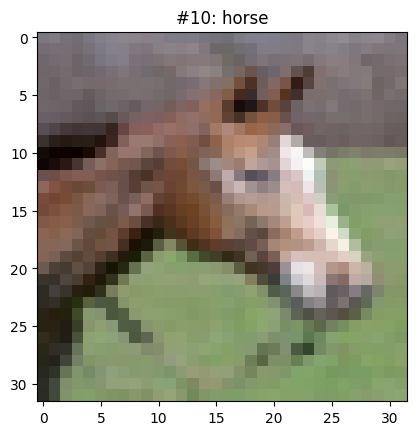

In [13]:
alive_idxs = torch.nonzero(active_units)
f_idx = alive_idxs[0] #change index to specify non-silent feature
f_acts = encoded[:, f_idx]
top_act_idxs = f_acts.abs().squeeze().topk(10)[1]
mu = np.array([0.4914, 0.4822, 0.4465]).reshape(1, 1, 3) #values taken from readme of https://github.com/huyvnphan/PyTorch_CIFAR10
sigma = np.array([0.2471, 0.2435, 0.2616]).reshape(1, 1, 3)

print(f' Showing top activating inputs for feature {f_idx.item()}:')
for i, top_idx in enumerate(top_act_idxs):
    img = np.transpose(np.squeeze(images[top_idx, :, :, :]), axes=(1, 2, 0))
    img = img*sigma + mu
    plt.imshow(img)
    plt.title(f'#{i+1}: {cifar10_labels[targets[top_idx].item()]}')
    plt.show()


Cosine similarity between features

In [14]:
sparse_autoencoder = SparseAutoencoder(cfg)
sparse_autoencoder.load_state_dict(torch.load('SAE_100_epochs_CIFAR10_test_vgg_bn13.pt'))

<All keys matched successfully>

In [15]:
feature_labels = np.array(['horse', 'dog', 'ship/deer', 'dog', '?', 'deer', 'ship', 'bird', 'automobile',
                  'airplane', 'cat', 'frog', 'frog', 'airplane', 'bird', '?', 'truck']) #these are the 
#labels derived from manual inspection of the top 10 activating images for each feature 
positions = range(alive_idxs.shape[0])

Encoder

torch.Size([4096, 17])
tensor(1.0000)


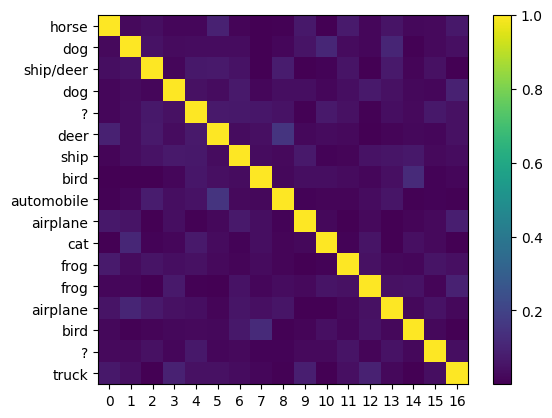

In [16]:
alive_idxs = torch.nonzero(active_units)
W_enc = sparse_autoencoder.W_enc[:, alive_idxs].squeeze().detach().clone()
W_enc = W_enc/W_enc.norm(dim=0)
print(W_enc.shape)
print(W_enc[:, 0].norm())
similarity_matrix =  (W_enc.transpose(0, 1)@W_enc).abs()

implot = plt.imshow(similarity_matrix)
plt.colorbar(implot)
_ = plt.yticks(positions, feature_labels)
_ = plt.xticks(positions)

Decoder

torch.Size([17, 4096])
tensor(1.)


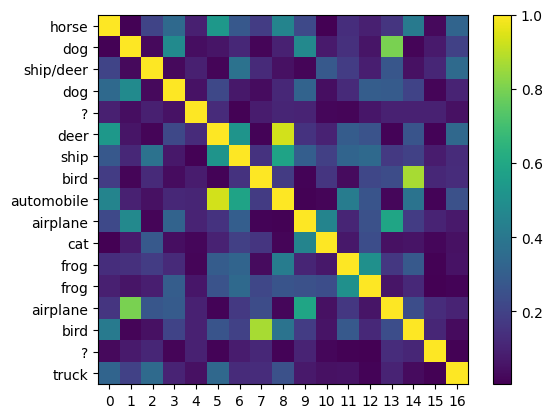

In [17]:
W_dec = sparse_autoencoder.W_dec[alive_idxs, :].squeeze().detach().clone()
W_dec = W_dec/W_dec.norm(dim=1).view(-1, 1)
print(W_dec.shape)
print(W_dec[0, :].norm())
similarity_matrix =  (W_dec@W_dec.transpose(0, 1)).abs()

implot = plt.imshow(similarity_matrix)
plt.colorbar(implot)
_ = plt.yticks(positions, feature_labels)
_ = plt.xticks(positions)